Ustawiamy parametry wyświetlania i font.

In [1]:
# encoding: utf-8
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7,7)#(10, 7)
matplotlib.rcParams.update({'font.family': 'Arial'})
matplotlib.rcParams.update({'font.size': 10})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Importujemy podstawowe moduły:

In [2]:
import numpy as np
import pylab as py
import pylab as plt

Importujemy funkcje specyficzne dla filtrowania w pythonie:

In [3]:
from  scipy.signal import freqz #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów

# Implementacja filtrowania: funkcja lfilter
## Dla przypomnienia: 
### Działanie filtra w dziedzinie czasu
Najczęściej, wyjście filtra jest kombinacją liniową:

$ y[n] = \sum_{i=0}^{n_b}b(i)x[n-i] - \sum_{i=1}^{n_a}a(i)y[n-i]$

gdzie: 

* $n_b$ liczba przeszłych próbek wejściowych $x$
* $n_a$ liczba przeszłych próbek wyjściowych $y$

użytych do obliczenia aktualnego wyjścia $y[n]$.
 
Większa z liczb  $n_b$ i $n_a$ określa "rząd" filtra.

Zauważmy, że matematycznie operacje te odpowiadają splataniu próbek wejściowych z wektorem $b$ i próbek wyjściowych z wektorem $a$.

### Implementacja w pythonie
Filtrowanie zgodne z powyższymi równaniami zaimplementowane jest w pythonie w module scipy.signal jako funkcja lfilter.

Podstawowe wywołanie tej funkcji dla sygnału `we` wygląda następująco: 

``wy = scipy.signal.lfilter(b,a,we)`` 

gdzie b, a są to współczynniki z poprzedniego równania.

# Badanie własności filtra w dziedzinie czasu i częstości:
Przy projektowaniu filtra musimy brać pod uwagę jego następujące własności:
- w dziedzinie częstości:
 - moduł transmitancji (funkcji przenoszenia) - jest to zależność modułu funkcji systemu od częstości  $\left|H\left(f\right)\right|$ 
 - opóźnienie grupowe
 - opóźnienie fazowe
- w dziedzinie czasu:
 - funkcję odpowiedzi impulsowej 
 - funkcję odpowiedzi schodkowej

## Zadanie: budujemy funkcję do ilustracji własności filtra
Nasza funkcja będzie przyjmowała na wejściu:
* współczynniki filtra ``a, b``, 
* wektor zawierający częstości ``f``, dla których własności mają być policzone,
* długość odcinka czasu, ``T``, na którym mają być prezentowane własności czasowe filtra,  
* oraz częstość próbkowania ``Fs``.

Funkcja ta będzie rysowała wszystkie powyżej wspomniane charakterystyki filtra.

In [4]:
def charkterystyki(a,b,f,T,Fs):
    t = np.arange(-T, T, 1/Fs)
    w = 2*np.pi* f/Fs
    w, h = freqz(b, a, w) 

    faza = np.unwrap(np.angle(h))
    df = np.diff(faza)
    idx, = np.where(np.abs(df-np.pi)<0.05)
    df[idx] = (df[idx+1]+df[idx-1])/2
    grupowe = - df/np.diff(w)
    opoznienieFazowe = - faza/w
    
    fig = py.figure()
    py.subplot(3,2,1)
    py.title('moduł transmitancji')
    m = np.abs(h)
    py.plot(f,20*np.log10(m))
    py.ylabel('[dB]')
    py.grid('on')
    
    
    py.subplot(3,2,3)
    py.title('opóźnienie fazowe')
    py.plot(f, opoznienieFazowe)
    py.ylabel('próbki')
    py.grid('on')
    
    py.subplot(3,2,5)
    py.title('opóźnienie grupowe')
    py.plot(f[:-1],grupowe)
    py.ylabel('próbki')
    py.xlabel('Częstość [Hz]')
    py.grid('on')
    py.ylim([0, np.max(grupowe)+1])
    
    py.subplot(3,2,2)
    py.title('odpowiedź impulsowa')
    x = np.zeros(len(t))
    x[len(t)//2] = 1
    y = lfilter(b,a,x)
    py.plot(t, x)
    py.plot(t, y)
    py.xlim([-T/2,T])
    py.grid('on')
    
    py.subplot(3,2,4)
    py.title('odpowiedź schodkowa')
    s = np.zeros(len(t))
    s[len(t)//2:] = 1
    ys = lfilter(b,a,s) # przepuszczamy impuls przez filtr i obserwujemy odpowiedź impulsową
    py.plot(t, s)
    py.plot(t, ys)
    py.xlim([-T/2,T])
    py.xlabel('Czas [s]')
    py.grid('on')
    
    fig.subplots_adjust(hspace=.5)
    py.show()
    

Testujemy:

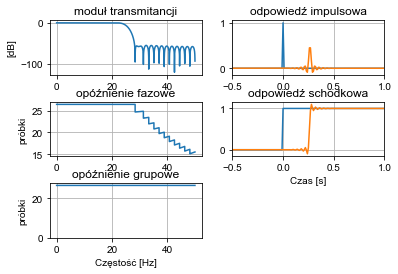

In [5]:
b = firwin(54,0.5)# licznik
a = np.array([1.0]) # mianownik
Fs = 100
T = 1
f = np.arange(0.01,Fs/2,0.01)
charkterystyki(a,b,f,T,Fs)

# Funkcje do projektowania filtrów
W bibliotece ``scipy.signal`` jest kilka funkcji do projektowania filtrów o zadanych parametrach. My skupimy się na dwóch zasadniczych grupach: 
* FIR - filtry o skończonej odpowiedzi impulsowej
* klasyczne IIR - filtry o nieskończonej odpowiedzi impulsowej

## FIR
Filtry typu FIR zwykle wymagają znacznie wyższych rzędów aby osiągnąć transmitancję o porządanej formie. Mają jednak dwie podstawowe zalety:
* ich funkcja odpowiedzi jest skończona opisana wektorem ``b`` - efekty brzegowe sięgają z obu końców filtrowanego sygnału na dokładnie połowę długości wektora ``b``
* mają liniową zależność fazy od częstości. Z tego powodu opóżnienie grupowe dla wszystkich częstości jest takie samo.

W module <tt>scipy.signal</tt> mamy kilka funkcji do projektowania filtrów typu FIR: ``firwin`` i ``firwin2``.

### firwin
Najprostszą koncepcyjnie metodą projektowania filtrów FIR jest metoda okienkowa.  
Metoda składa się z następujących kroków: 
* w dziedzinie częstości projektowana jest idealna funkcja przenoszenia, 
* obliczana jest od niej odwrotna transformata Fouriera, 
* następnie otrzymana sekwencja czasowa (odpowiedź impulsowa) jest przemnażana przez wybrane okno.

Metoda ta zaimplementowana jest w funkcji 
<tt>scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True, scale=True, nyq=1.0)</tt>.

Pozwala ona projektować filtry dolno- i górno- przepustowe oraz pasmowo przepustowe i pasmowo zaporowe metodą okienkową.

Najważniejsze parametry (kompletny opis w dokumentacji) http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html#scipy.signal.firwin

* ``numtaps``: int, ilość współczynników filtru (rząd filtru+1). Liczba ta musi być parzysta jeśli pasmo przenoszenia ma zawierać częstość Nyquista.
* <tt>cutoff</tt>: częstość odcięcia filtru. Może być jedną liczbą zmiennoprzecinkową dla filtru dolno- lub górno- przepustowego lub tablicą dla filtrów pasmowych. Wyrażamy ją w tych samych  jednostkach co <tt>nyq</tt> i musi zawierać się pomiędzy 0 a <tt>nyq</tt>. 
* <tt>window</tt>: napis lub krotka: określa jakiego okna użyć do projektu filtru. Może to być dowolne okno spośród opisanych w <tt>scipy.signal.get_window</tt> 
* <tt>pass_zero</tt>: bool, Jeśli True to zero jest przenoszone, jeśli False to nie jest. Ten parametr decyduje jak jest interpretowane pierwsze pasmo od 0 do <tt>cutoff</tt> - czy ma to być pasmo przenoszone czy tłumione.
* <tt>nyq</tt>: float. Częstość Nyquista.
* Zwraca: współczynniki <tt>b</tt>


### Przykłady: Zbadaj włsności przykładowych projektów
We wszystkich poniższych przykładach zakładamy, że częstość próbkowania wynosi 256Hz:

* filtr dolnoprzepustowy rzędu 20 z częstością odcięcia 40Hz:

 * ``firwin(21, 40, nyq= 128)``

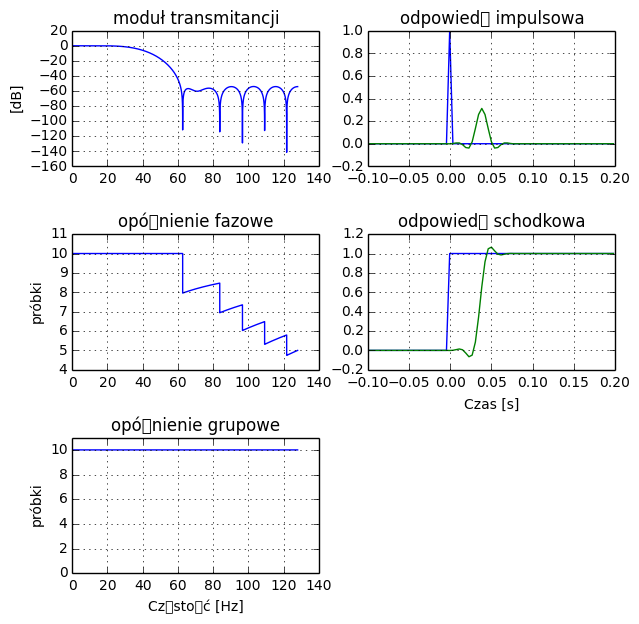

In [25]:
Fs = 256
T = 0.2
f = np.arange(0.01,Fs/2,0.01)
b = firwin(21, 40, nyq= 128)
charkterystyki(1,b,f,T ,Fs)

*  filtr górnoprzepustowy rzędu 15 z częstością odcięcia 5 Hz: 
 * ``firwin(17, 15, nyq= 128, pass_zero=False)``

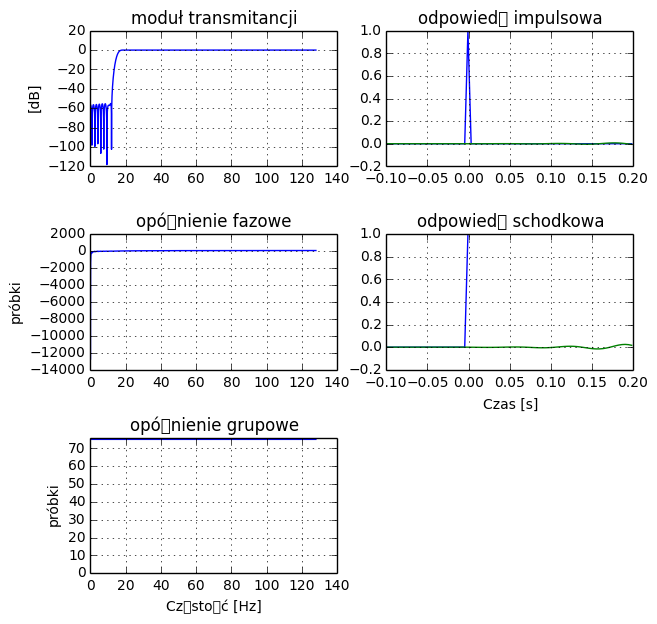

In [26]:
Fs = 256
T = 1
f = np.arange(0.01,Fs/2,0.01)

b = firwin(151, 15, nyq= 128, pass_zero=False)
charkterystyki(1,b,f,T = 0.2,Fs=Fs)

*  pasmowo przepustowy 51 rzędu przenoszący częstości pomiędzy 8 a 14 Hz: 
 * ``firwin(51, [8, 14], nyq= 128, pass_zero=False)``

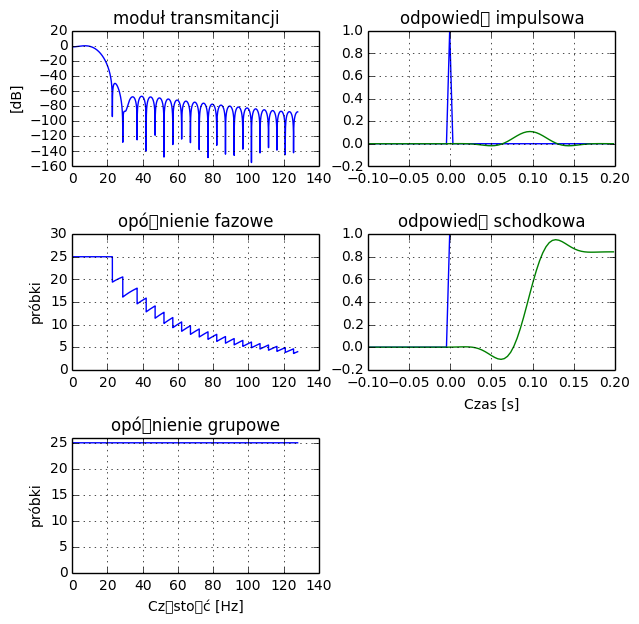

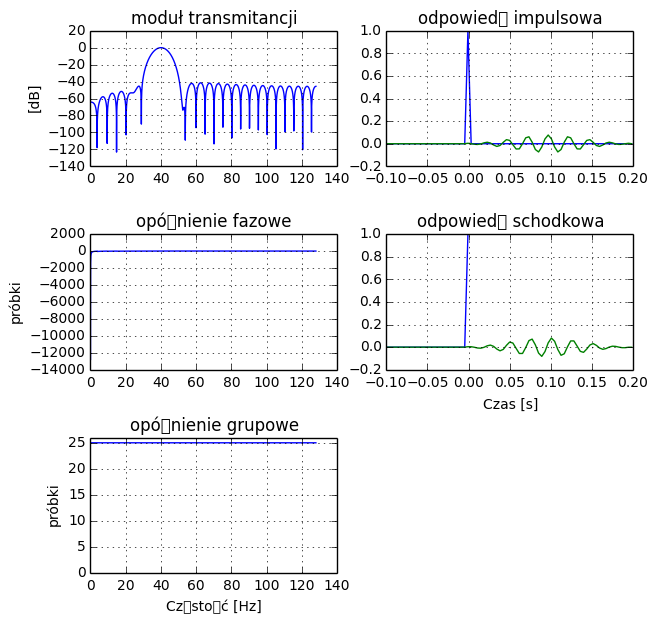

In [27]:
Fs = 256
f = np.arange(0.01,Fs/2,0.01) 

b=firwin(51, [1, 14], nyq= Fs/2, pass_zero=False)
charkterystyki(1,b,f,T = 0.2,Fs=Fs)
b=firwin(51, [38,42], nyq= Fs/2, pass_zero=False)
charkterystyki(1,b,f,T = 0.2,Fs=Fs)

### Zadanie: Zaprojektuj i zbadaj własności filtra:
FIR gornoprzepstowy z pasmem przenoszenia od 30 Hz dla sygnału próbkowanego 256 Hz

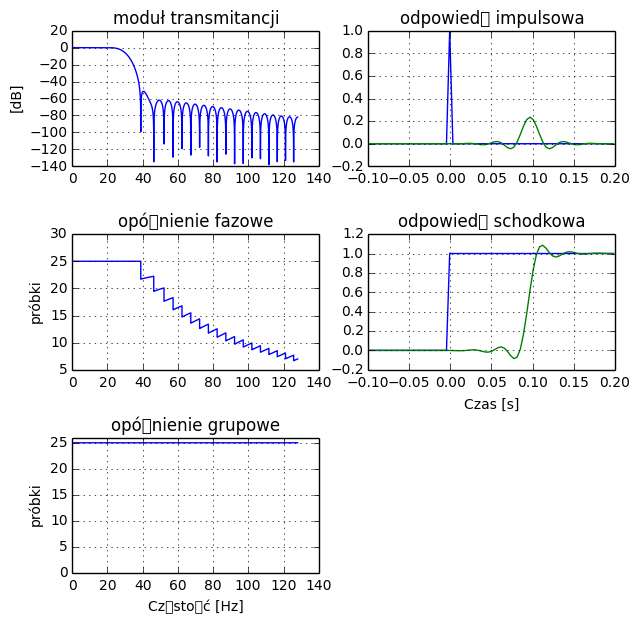

In [28]:
Fs = 256
T = 0.2
f = np.arange(0.01,Fs/2,0.01)
b=firwin(51, 30, nyq= Fs/2, pass_zero=True)
charkterystyki(1,b,f,T ,Fs)

### Zadanie: Znajdź rząd filtra FIR:
dolnoprzepustowego z pasmem przenoszenia do 40 Hz dla sygnału próbkowanego 256 Hz, tak aby dla częstości powyżej 45 Hz jego tłumienie było nie mniejsze niż 20dB.

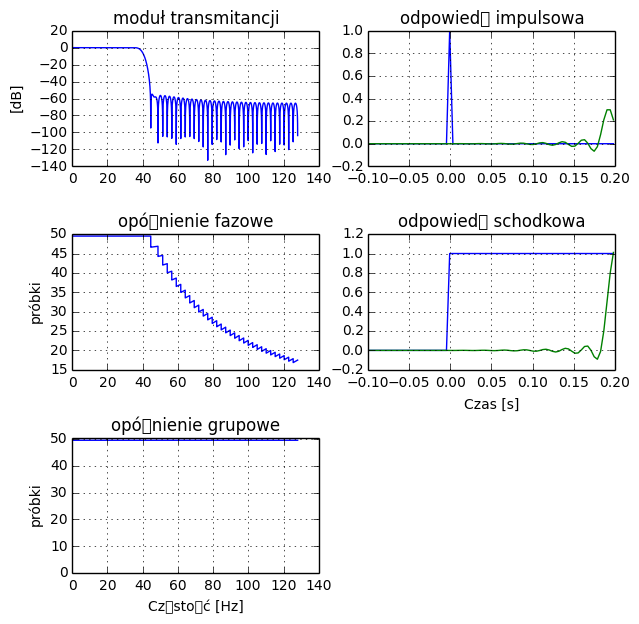

In [29]:
Fs = 256
T = 0.2
f = np.arange(0.01,Fs/2,0.01)

b=firwin(100, 40, nyq= Fs/2, pass_zero=True)
charkterystyki(1,b,f,T ,Fs)

### firwin2

Funkcja 

``scipy.signal.firwin2(numtaps, freq, gain, nfreqs=None, window='hamming', nyq=1.0)``

również implementuje okienkową metodę projektowania filtrów FIR. Daje ona nieco większą swobodę w kształtowaniu idealnej funkcji przenoszenia. Zadaje się ją przez podanie dwóch wektorów: 
* ``freq`` i Wektor freq definiuje punkty w częstości (jednostki takie same jak ``nyq``, muszą zawierać 0 i ``nyq``) dla których znana jest wartość pożądanego przenoszenia.  Wartości ``freq`` muszą być ułożone w kolejności rosnącej, dopuszczalne jest powtórzenie tej samej wartości częstości i odpowiadających im różnych wartości gain aby zdefiniować nieciągłość funkcji przenoszenia.
* ``gain`` Pożądane wartości przenoszenia odpowiadające kolejnym częstościom definiowane są w ``gain``.
* Znaczenie pozostałych parametrów jest takie samo jak dla ``firwin.

### Zadanie: filtr wielopasmowy
Zaprojektuj filtr przenoszący częstości w pasmach pomiędzy : 10-11, 20-21 i 30-31 Hz, który w paśmie zaporowym ma co najmniej 60 dB tłumienia. 

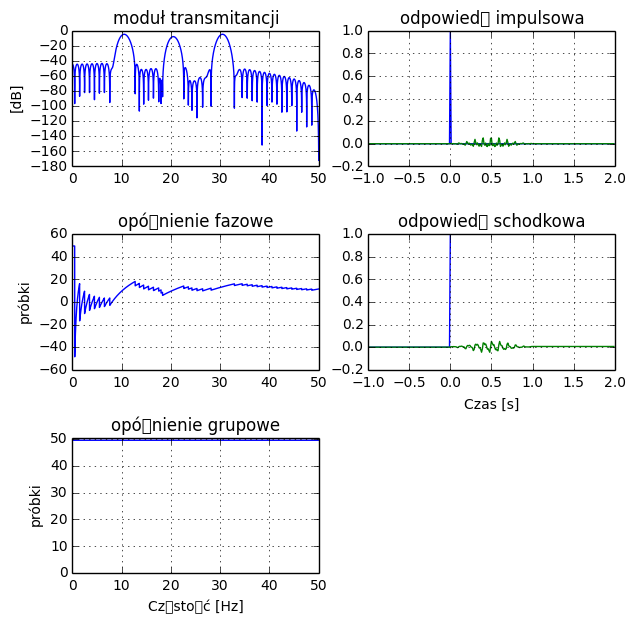

In [30]:
Fs =100
T = 2
f = np.arange(0.01,Fs/2,0.01) 
freq = np.array([0, 10, 10, 11, 11, 20, 20, 21, 21, 30, 30, 31, 31, 50])
gain = np.array([0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0])
b = firwin2(100, freq, gain, nyq= 50)
charkterystyki(1,b,f,T,Fs)

# Filtry IIR
Filtry o nieskończonej odpowiedzi impulsowej (''infinite impulse response'', IIR) mają zazwyczaj dużo niższe rzędy niż filtry o skończonej odpowiedzi impulsowej (''finite impulse response'', FIR) z analogicznym poziomem tłumienia i szerokością pasma przejściowego.

W module <tt>scipy.signal</tt> mamy zaimplementowane kilka funkcji do projektowania &bdquo;optymalnych&rdquo; pod różnymi względami filtrów w klasycznych konfiguracjach:
dolno- albo górnoprzepustowe i pasmowo-przepustowe albo pasmowo-zaporowe.

## Funkcje do projektowania filtrów IIR dostępne w module <tt>scipy.signal</tt>
W module <tt>scipy.signal</tt> dostępne są funkcje do projektowania czterech typów filtrów: Butterwortha, Czebyszewa typu I i II, oraz eliptyczny.
Do opisu wymagań projektowych funkcje te wykorzystują następujące pojęcia:
* <tt>wp</tt>, <tt>ws</tt> &mdash; krawędzie pasma przenoszenia i tłumienia. **Częstości są znormalizowane do zakresu od 0 do 1 (1 odpowiada częstości Nyquista)** przykładowo:
* * dolno-przepustowy:  <tt>wp = 0.2</tt>,          <tt>ws = 0.3</tt>
* * górno-przepustowy:  <tt>wp = 0.3</tt>,          <tt>ws = 0.2</tt>
* * pasmowo-przepustowy:  <tt>wp = [0.2, 0.5]</tt>,   <tt>ws = [0.1, 0.6]</tt>
* * pasmowo-zaporowy:  <tt>wp = [0.1, 0.6]</tt>,   <tt>ws = [0.2, 0.5]</tt>
* <tt>gpass</tt> &mdash; maksymalna dopuszczalna strata w pasmie przenoszenia (w funkcjach projektujących filtry jest to <tt>rp</tt>) (dB).
* <tt>gstop</tt> &mdash; minimalne wymagane tłumienie w pasmie tłumienia (w funkcjach projektujących filtry jest to <tt>rs</tt>) (dB).
* <tt>btype</tt> &mdash; typ filtra (<tt>'lowpass'</tt>, <tt>'highpass'</tt>, <tt>'bandpass'</tt>, <tt>'bandstop'</tt>).

Funkcje do projektowania filtrów są zaimplementowane parami: 
* jedna pomaga dobierać rząd filtru do wymagań projektowych, 
* druga oblicza współczynniki filtru. 

W poniższych przykładach przyjmiemy:

In [31]:
T = 0.3
Fs = 100 # Hz
f = np.arange(0.01,Fs/2,0.01)

wp = 10/(Fs/2)
ws = 30/(Fs/2)
gpass = 1 
gstop = 25
analog=0
rp = gpass
rs = gstop

### Filtr Butterwortha
daje gładką (bez tętnień) funkcję przenoszenia w całym zakresie częstości.

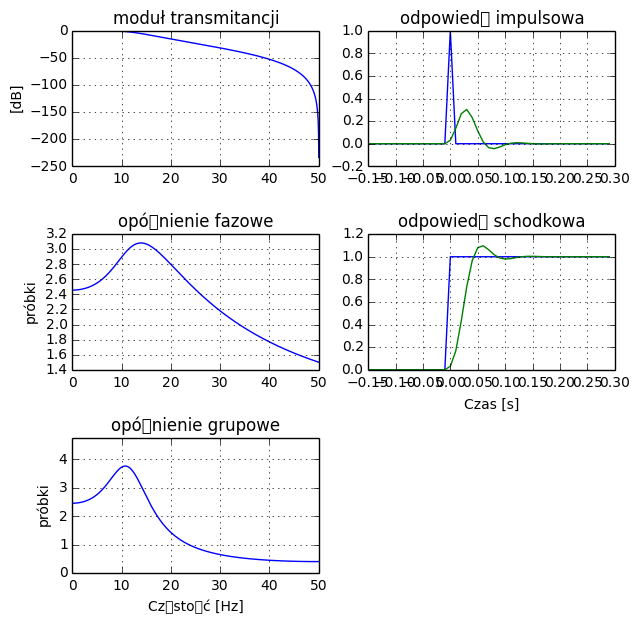

Filtr Butterwortha, rząd: 3, częstość odcięcia 12.303


In [32]:
[n,Wn]=buttord(wp, ws, gpass, gstop)
[b,a]=butter(n,Wn)
charkterystyki(a,b,f,T,Fs)
print('Filtr Butterwortha, rząd: {}, częstość odcięcia {:.3f}'.format(n,Wn*Fs/2))

### Filtr Czebyszewa I rodzaju 

gładka funkcja przenoszenia w paśmie tłumienia, minimalizowane są tętnienia  w paśmie przenoszenia

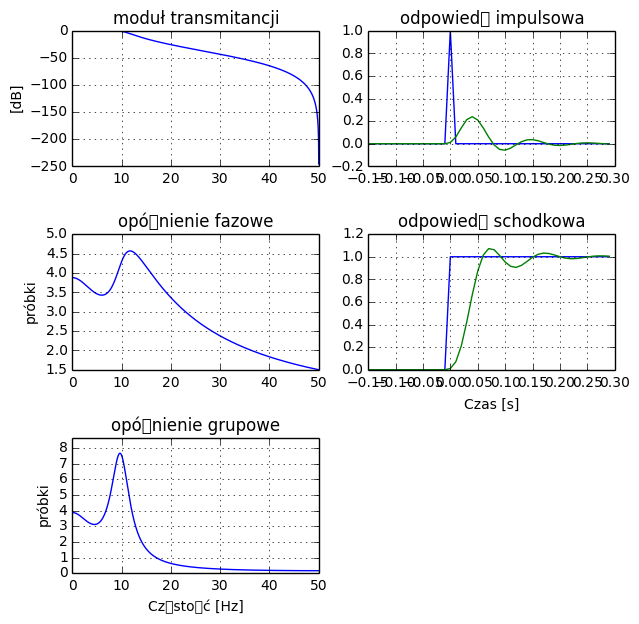

Czebyszewa I Typu: rząd: 3, częstość odcięcia 10.000


In [33]:
[n,Wn]=cheb1ord(wp, ws, gpass, gstop, analog)
[b,a]=cheby1(n, rp, Wn, btype='low',  output='ba')
charkterystyki(a,b,f,T,Fs)
print('Czebyszewa I Typu: rząd: {}, częstość odcięcia {:.3f}'.format(n,Wn*Fs/2))

### Filtr Czebyszewa II rodzaju

gładka funkcja przenoszenia w paśmie przenoszenia, minimalizowane tętnienia w paśmie tłumienia

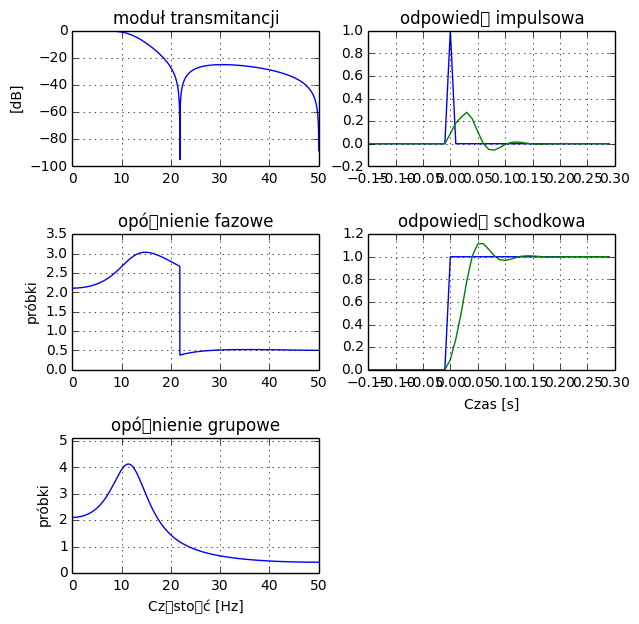

Czebyszewa II Typu: rząd: 3, częstość odcięcia 19.616


In [34]:
[n,Wn]=cheb2ord(wp, ws, gpass, gstop, analog=0);
[b,a]=cheby2(n, rs, Wn, btype='low', analog=0, output='ba')
charkterystyki(a,b,f,T,Fs)
print('Czebyszewa II Typu: rząd: {}, częstość odcięcia {:.3f}'.format(n,Wn*Fs/2))

### Filtr eliptyczny 
daje najostrzejsze przejście pomiędzy pasmem tłumienia i przenoszenia przy tym samym rzędzie w porównaniu z wyżej wymienionymi filtrami, tętnienia są obecne zarówno w paśmie przenoszenia jak i w paśmie tłumienia


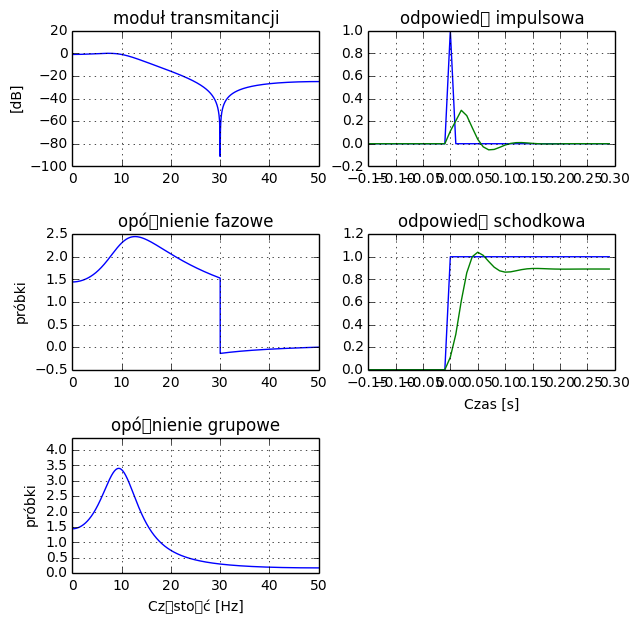

Eliptyczny: rząd: 2, częstość odcięcia 10.000


In [35]:
[n,Wn]=ellipord(wp, ws, rp,rs);
[b,a]=ellip(n, rp, rs, Wn, btype='low', analog=0, output='ba')
charkterystyki(a,b,f,T,Fs)
print('Eliptyczny: rząd: {}, częstość odcięcia {:.3f}'.format(n,Wn*Fs/2))

## Filtrowanie z zerowym przesunięciem fazowym
### Zadanie
Filtrowanie sygnałów off-line można zrealizować tak, aby sygnał wyjściowy nie miał przesunięcia fazowego. 
Procedura powyższa zaimplementowana jest w funkcji: scipy.signal.filtfilt. Jej działanie i porównanie z efektami funkcji lfilter przedstawia poniższy przykład:

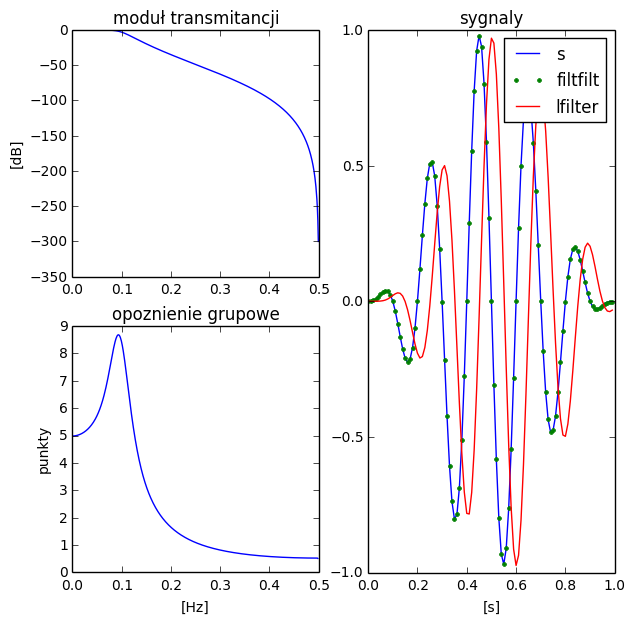

In [36]:
# częstość próbkowania
Fs = 100.0
# projekt dolnoprzepustowego filtra Butterwortha 5 rzędu
# o częstości odcięcia 10 Hz  
Wn=10/(Fs/2)
[b,a] = butter(5,Wn)
 
# obliczamy funkcję przenoszenia
w,h = freqz(b,a)
transmitancja =20*np.log10(np.abs(h))
 
    
#opóźnienie grupowe
grupowe = -np.diff(np.unwrap(np.angle(h)))/np.diff(w)  
 
# przeliczamy skalę w (radiany) na częstości w Hz 
f = w/(2*np.pi)
 
# generujemy sygnał
t = np.arange(0,1,1/Fs)
s = np.sin(2*np.pi*5*t)*np.hanning(len(t))
 
# Filtrowanie z zerowym opoznieniem fazowym
y = filtfilt(b,a,s)
 
# Filtrowanie standardowe
y1 = lfilter(b,a,s)
 
# WYKRESY
py.subplot(2,2,1)
py.plot(f,transmitancja) # przeliczenie modułu transmitancji na dB
py.title('moduł transmitancji')
py.ylabel('[dB]')
 
py.subplot(2,2,3)
py.plot(f[:-1], grupowe )
py.title('opoznienie grupowe')
py.xlabel('[Hz]')
py.ylabel('punkty')
 
py.subplot(1,2,2)
py.plot(t,s)
py.plot(t,y,'g.')
py.plot(t,y1,'r')
py.legend(('s','filtfilt','lfilter'))
py.xlabel('[s]')
py.title('sygnaly')
py.show()

### Zadanie

Skonstruować filtry dolnoprzepustowe rzędu n=5, o częstości odcięcia 30 Hz przy częstości próbkowania sygnału 128 Hz, rp = 0,5 dB, rs = 20 dB, przy pomocy wszystkich podanych powyżej funkcji i porównać ich własności.

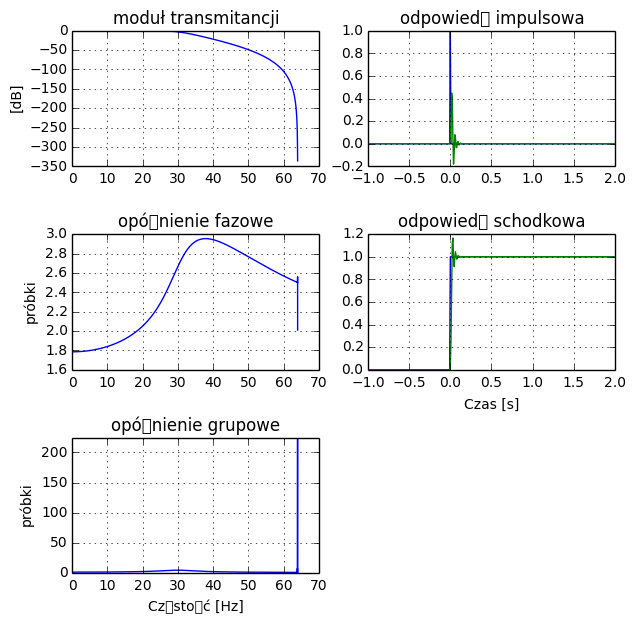

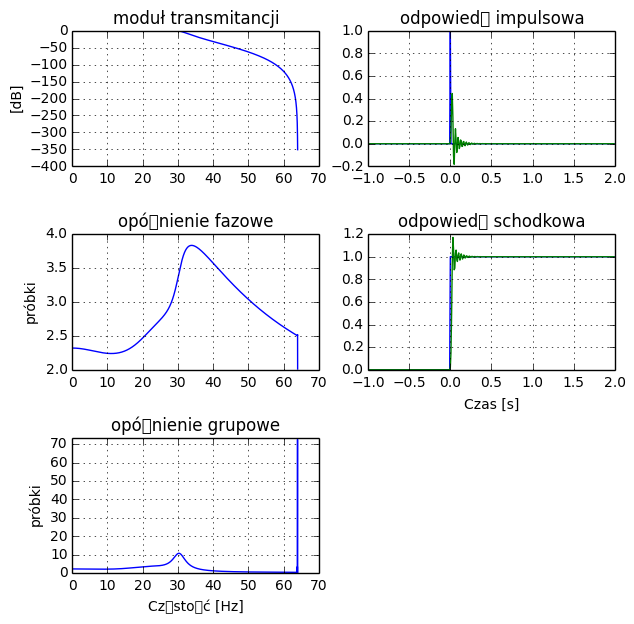

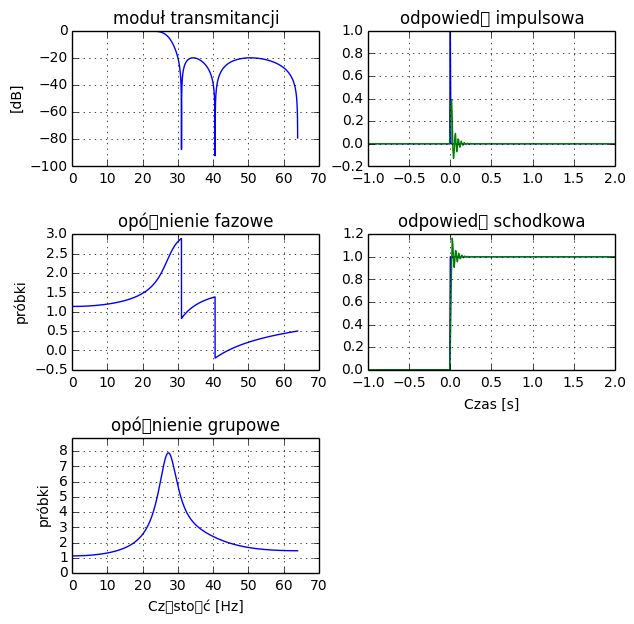

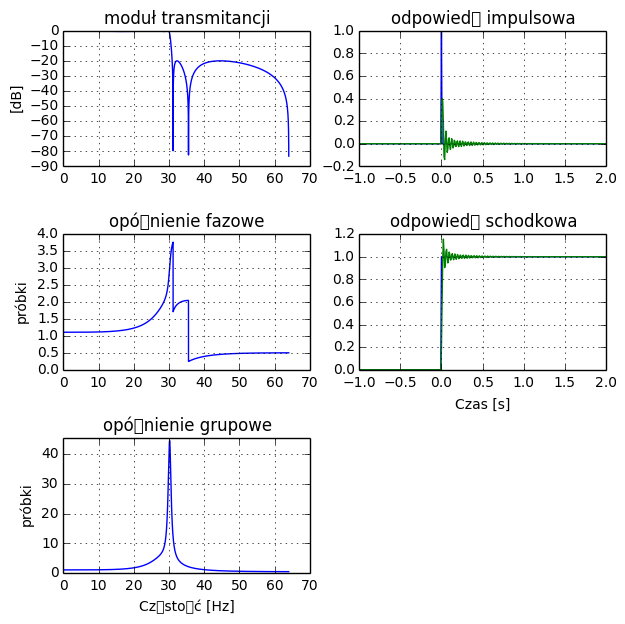

In [40]:
Fs = 128
n = 5
Wn = 30/(Fs/2)
[b,a]=butter(n,Wn)
T = 2
f = np.arange(0.01,Fs/2,0.01) 
charkterystyki(a,b,f,T,Fs)

rp = 0.5
[b,a]=cheby1(n, rp, Wn, btype='low',  output='ba')
charkterystyki(a,b,f,T,Fs)

rs = 20
[b,a]=cheby2(n, rs, Wn, btype='low', analog=0, output='ba')
charkterystyki(a,b,f,T,Fs)

[b,a]=ellip(n, rp, rs, Wn, btype='low', analog=0, output='ba')
charkterystyki(a,b,f,T,Fs)

### Zadanie
Dobrać rząd i zaprojektować, a następnie zbadać własności otrzymanego filtru Butterwortha spełniającego poniższe kryteria:
pasmo przenoszenia 1000-2000 Hz, pasmo tłumienia zaczyna się 500 Hz od każdego z brzegów pasma przenoszenia,
próbkowanie 10 kHz, najwyżej 1 dB tętnienia w paśmie przenoszenia, co najmniej 60 dB tłumienia w paśmie tłumienia.

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


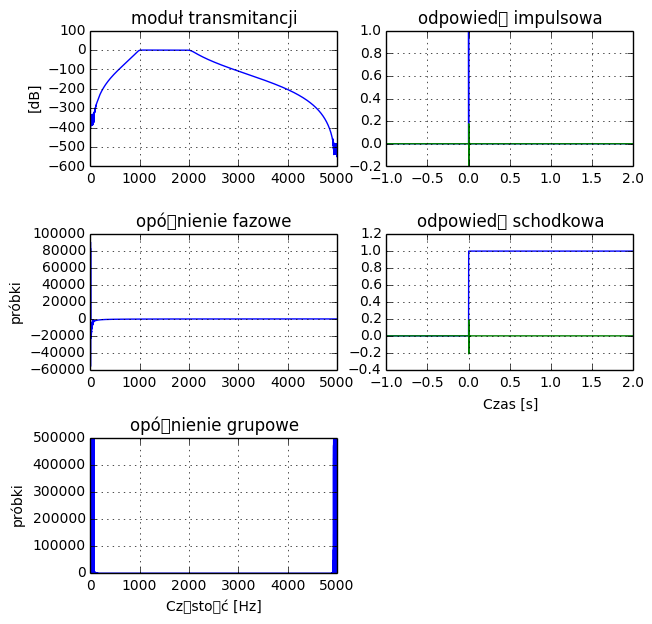

In [45]:
Fs = 10000
wp = [1000/(Fs/2),2000/(Fs/2)]
ws = [500/(Fs/2), 2500/(Fs/2)]
gpass = 1
gstop = 60
f = np.arange(0.01,Fs/2,0.01) 
[n,Wn]=buttord(wp, ws, gpass, gstop)
[b,a]=butter(n,Wn, btype = 'bandpass')
charkterystyki(a,b,f,T,Fs)

### Zadanie: filtr pasmowy do wyszukiwania wrzecion snu
Zaprojektować filtr do wyławiania wrzecion snu z sygnału. Wrzeciona snu to struktury w sygnale EEG rejestrowanym w czasie snu zawierające się w paśmie 11-15 Hz.
Działanie filtra przetestować na sygnale:

http://www.fuw.edu.pl/~jarekz/SYGNALY/TF/c4spin.txt

Sygnał ten to fragment zapisu EEG z II stadium snu elektroda C4 próbkownie 128Hz.

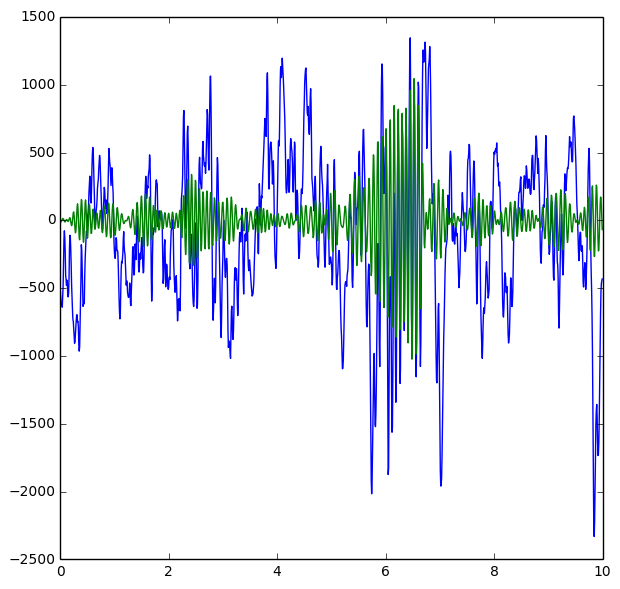

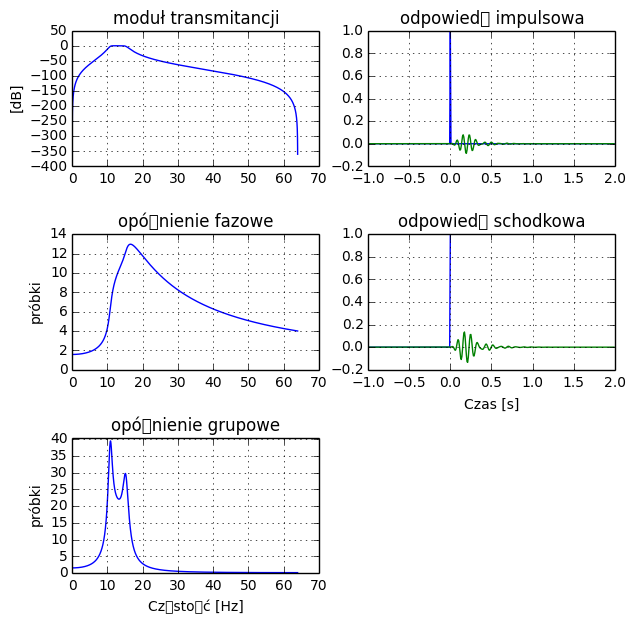

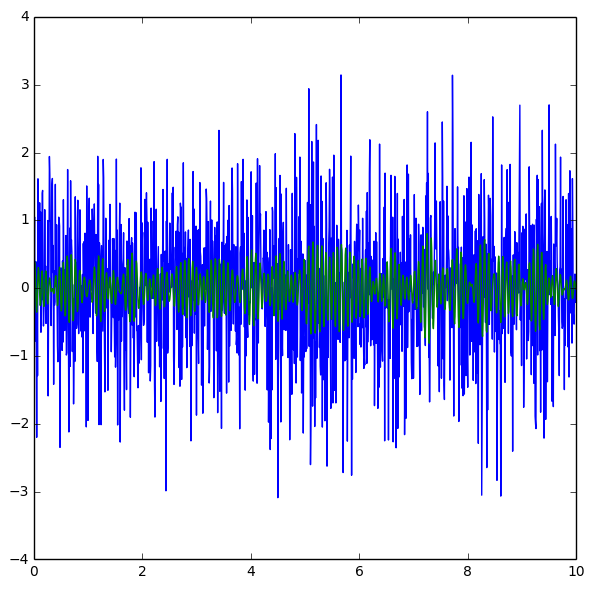

In [59]:
s = np.loadtxt('c4spin.txt') # wczytujemy sygnał z pliku tekstowego
Fs = 128
t = np.arange(0,len(s)/Fs, 1/Fs) # przygotowujemy oś czasu
wp = [11/(Fs/2),15/(Fs/2)]
ws = [8/(Fs/2), 18/(Fs/2)]
gpass = 1
gstop = 20
[n,Wn]=buttord(wp, ws, gpass, gstop)
f= np.arange(0.01,Fs/2,0.01)
py.plot(t, s)
[b,a] = butter(n,Wn, btype = 'bandpass')
sf = filtfilt(b,a,s)
py.plot(t,sf)
py.show()
charkterystyki(a,b,f,T,Fs)

szum =np.random.randn(len(s))
py.plot(t, szum)
[b,a] = butter(n,Wn, btype = 'bandpass')
sf = filtfilt(b,a,szum)
py.plot(t,sf)
py.show()

### Zadanie 5: uwaga na odpowiedź impulsową

Przydadzą nam się pliki: 
* https://drive.google.com/open?id=0BzwQ_Lscn8yDNGc0aU5jSDFFMmc Plik z sygnałem EKG
* https://drive.google.com/open?id=0BzwQ_Lscn8yDOF9jX0pjcG9LSGc Plik z metadanymi do tego sygnału

Proszę:
* wykreślić pierwsze 10 sekund sygnału
* zastosować filtr górnoprzepustowy Butterwartha o częstościach odcięcia: 0.01, 0.1, 0.5 -> zaobserwuj jak długo stabilizuje się sygnał
* Zastosuj filtr pasmowoprzepustowy (11 - 14 Hz) i wykreśl wynik jego zastosowania na tle poprzedniej wersji sygnału. Zinterpretuj wynik w kontekście funkcji odpowiedzi impulsowej tego filtra.

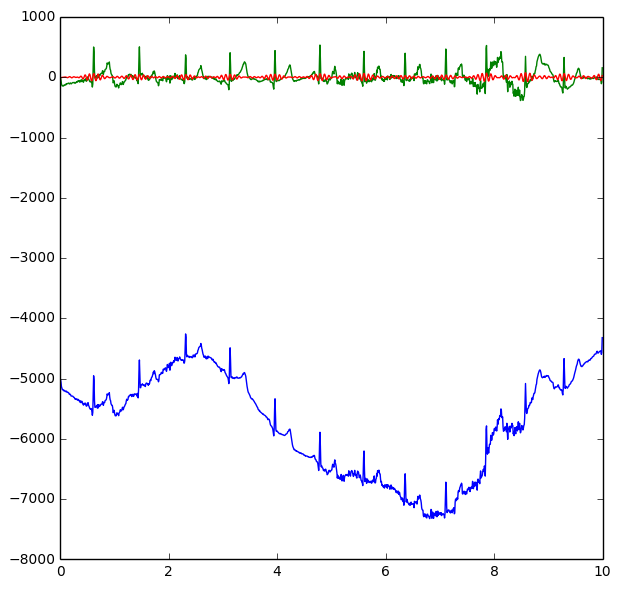

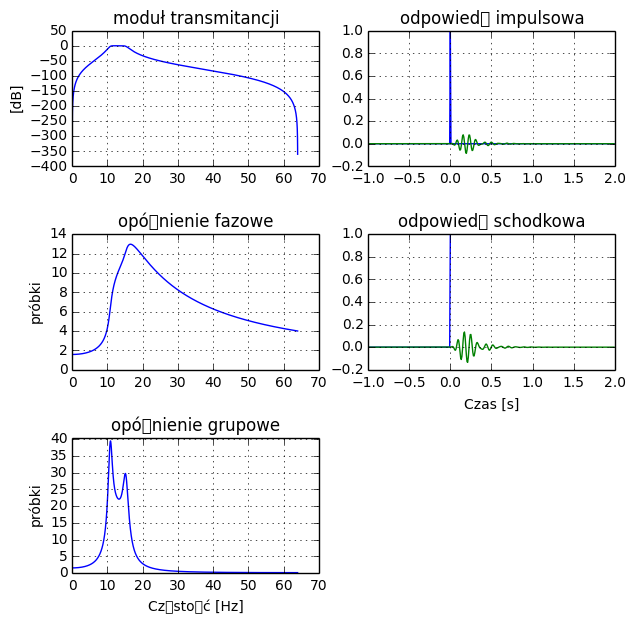

In [67]:
s = np.fromfile('EKG.bin', dtype='<f') # tworzymy tablicę sig o typie określonym przez ''dtype''                                
# ustawiamy częstość próbkowania
Fs = 128
# tworzymy wektor czasu
t = np.arange(0,len(s))/Fs
f= np.arange(0.01,Fs/2,0.01)
# ustalamy zakres indeksów sygnału i czasu do wyświetlania
zakres =  np.logical_and(0<t, t<10)

py.plot(t[zakres],s[zakres])
# filtr górnoprzepustowy (0.01, 0.1, 0.5)
n=5
Wn=0.01
[bl,al] = butter(n,Wn, btype='highpass')
sf = filtfilt(bl,al,s)
py.plot(t[zakres],sf[zakres])

# filtr pasmowy 
wp=[11/(Fs/2),14/(Fs/2)]
ws=[8/(Fs/2),17/(Fs/2)]
gpass = 1
gstop = 60
[n,Wn]=buttord(wp, ws, gpass, gstop)
[bl,al]=butter(n,Wn, btype = 'bandpass')
sf_l = filtfilt(bl,al,sf)
py.plot(t[zakres],sf_l[zakres])
charkterystyki(a,b,f,T,Fs)
py.show()

### Zadanie: Uwaga na odpowiedź schodkową
Wykorzystajmy fragment sygnału EKG z poprzedniego zadania (pomiędzy 12 a 40 -tą sekundą).
* wykreśl ten fragment
* zaprojektuj filtr górnoprzepustowy Butterwortha o częstości odcięcia 0.1 (potem 0.5), rzedu 1 (potem 5), 
* przefiltruj sygnał z tymi współczynnikami za pomocą funkcji `filtfilt` i `lfilter` ,
* dodaj do sygnału z lewej strony jego kopię odwróconą w czasie,
* ten sygnał przefiltruj funkcją `lfilter` i wykreśl jego drugą połowę,
* zinterpretuj uzyskane wyniki w kontekście funkcji odpowiedzi impulsowej.

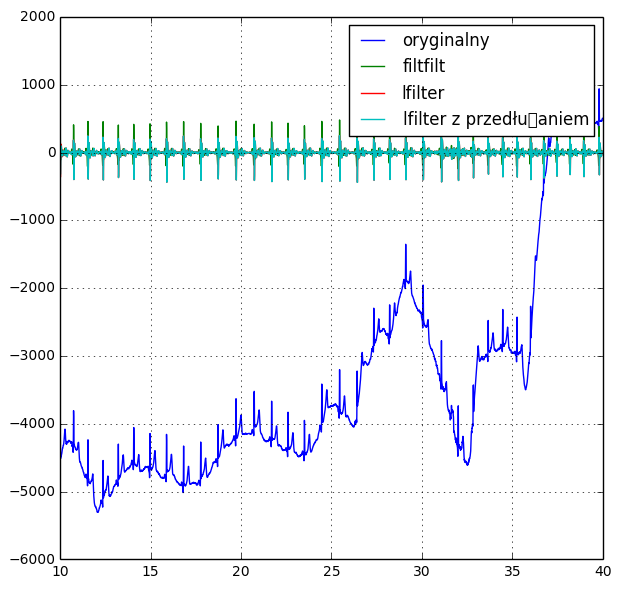

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide


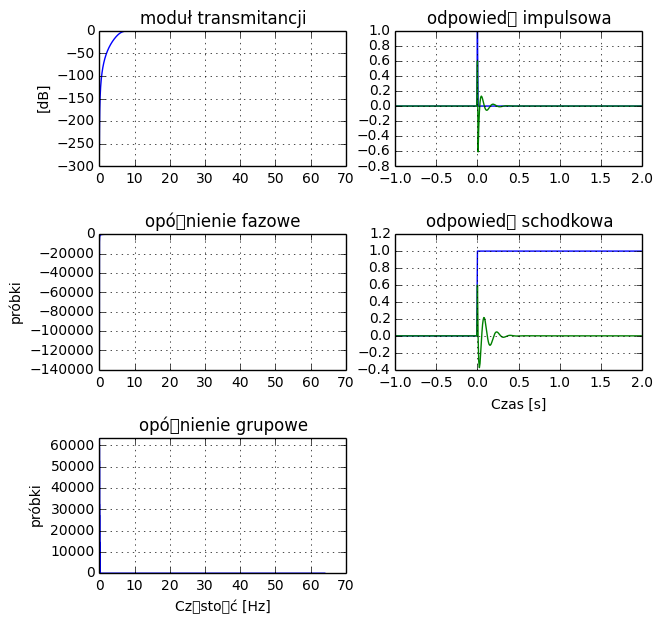

In [76]:
s = np.fromfile('EKG.bin', dtype='<f')
Fs=128
zakres =  np.logical_and(10<t, t<40)
t_z = t[zakres]
s_z = s[zakres]
py.plot(t_z,s_z, label = 'oryginalny')
py.grid('on')

# filtr górnoprzepustowy ( 0.1, 0.5)
n=5
Wn=0.1
[b,a] = butter(n,Wn,btype='highpass')
sff = filtfilt(b,a,s)
py.plot(t_z, sff[zakres], label = 'filtfilt')

# lfilter
sfl = lfilter(b,a,s)
py.plot(t_z,sfl[zakres],label = 'lfilter')

# lfilter z przedłużeniem 
x=np.concatenate((s_z[::-1],s_z))
sfl_p = lfilter(b,a,x)
py.plot(t_z,sfl_p[len(t_z):],label = 'lfilter z przedłużaniem')
py.legend()
py.show()
f=np.arange(0,Fs/2,0.001)
charkterystyki(a,b,f,T,Fs)

## Przepróbkowywanie

### Przepróbkowywanie do góry: 
Zwiększamy częstość prókowania całkowitą ilość razy P

Najpowszechniej stosowana metoda polega na dodaniu P zer pomiędzy istniejące próbki sygnału tak aby osiągnął on P-krotnie większą długość. Następnie taki rozciągnięty sygnał filtrujemy filtrem dolnoprzepustowym o częstości odcięcia nie większej niż częstość Nyquista oryginalnego sygnału — rozciąganie sygnału nie dokłada do niego nowej informacji więc i tak nic nie tracimy.
Przykład przepróbkowania do góry:



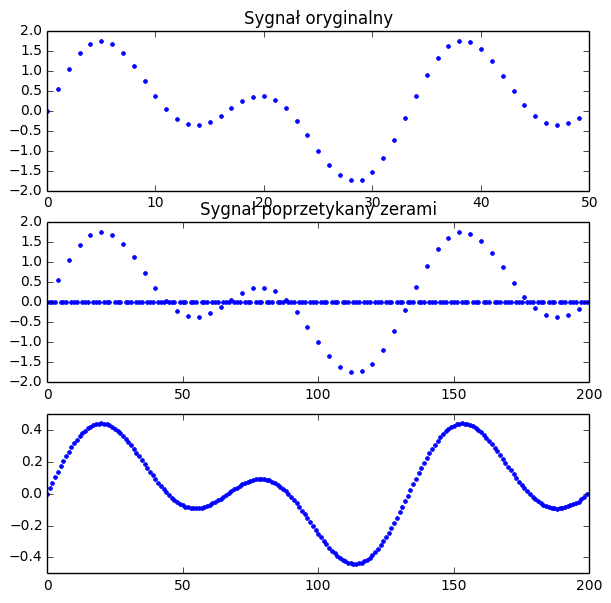

In [77]:
t = np.arange(0,0.05,0.001) # czas
x = np.sin(2*np.pi*30*t) + np.sin(2*np.pi*60*t) # sygnał
stare_Fs = 100 
py.subplot(3,1,1)
py.plot(x,'.')
py.title('Sygnał oryginalny')

py.subplot(3,1,2)
X = np.zeros(4*len(x))
nowe_Fs = 400
X[::4] = x
py.plot(X,'.')
py.title('Sygnał poprzetykany zerami')

[b,a] = butter(8,stare_Fs/nowe_Fs) # filtr powinien przepuszczać tylko te częstości, 
                        # które były w oryginalnym sygnale tzn. poniżej pierwotnego Nyqista
y = filtfilt(b,a,X); # filtrujemy dolnoprzepustowo  
py.subplot(3,1,3)
py.plot(y,'.')
py.show()

### Przepróbkowanie do dołu: 
Zmniejszamy częstość próbkowania całkowitą ilość razy.
Musimy pamiętać o tym, żeby wyfiltrować to, co było w oryginalnym sygnale powyżej docelowego Nyquista, żeby uniknąć aliasingu w wynikowym sygnale.

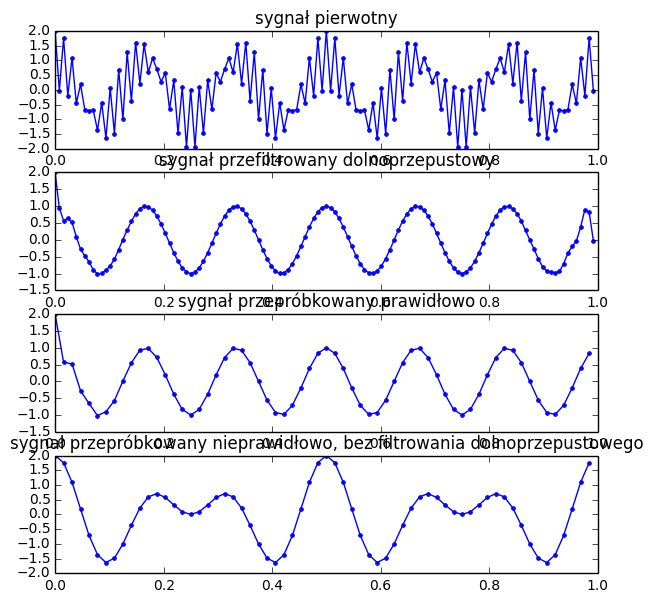

In [88]:
Fs1 = 128.0 # pierwotna częstość próbkowania [Hz]
FN1 = Fs1/2 # pierwotna częstość Nyquista
 
t = np.arange(0,1,1.0/Fs1) # czas probkowany 1/Fs1
f1 = 6 # Hz
f2 = 60
fi = np.pi/2
s = np.sin(2*np.pi*t*f1+fi) + np.sin(2*np.pi*t*f2+fi)
plt.subplot(4,1,1)
plt.plot(t,s,'.-')
plt.title(u'sygnał pierwotny')
# obnizamy czestosc probkowania k razy
k = 2
Fs2 = Fs1/k # nowa czestosc probkowania jest k razy niższa
FN2 = Fs2/2 # nowa częstość Nyquista
[b,a] = butter(8,FN2/FN1) # przefiltrujemy filtrem dolnoprzepustowym
                          # tak aby nic nie zostało powyzej
                          # docelowej częstości Nyquista 
ss = filtfilt(b,a,s);
t2 = np.arange(0,1,1.0/Fs2) 
plt.subplot(4,1,2)
plt.plot(t,ss,'.-')
plt.title(u'sygnał przefiltrowany dolnoprzepustowy')
 
plt.subplot(4,1,3)
ss2 = ss[::k]
plt.plot(t2,ss2,'.-')
plt.title(u'sygnał przepróbkowany prawidłowo')
 
plt.subplot(4,1,4)
ss3 = s[::k]
plt.plot(t2,ss3,'.-')
plt.title(u'sygnał przepróbkowany nieprawidłowo, bez filtrowania dolnoprzepustowego')
plt.show()

### Zmiana częstości o wymierną ilość razy:

Zmieniamy częstość próbkowania o wymierną $\frac{P}{Q}$ liczbę razy — uzyskujemy składając powyższe kroki tzn. najpierw zwiększamy częstość P-krotnie, a następnie zmniejszamy Q-krotnie.

### Zadanie 6
Proszę napisać funkcję, która będzie przepróbkowywać sygnał o wymierną liczbę razy. Funkcja powinna przyjmować sygnał, częstość próbkowania, parametry P i Q i zwracać przepróbkowany sygnał i nową częstość próbkowania

ValueError: could not broadcast input array from shape (50) into shape (500)

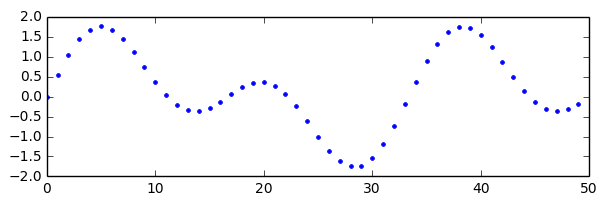

In [86]:
def resample(s,fs,P=1,Q=1):
    if P>1 and isinstance(P,int):
        sP = np.zeros(P*len(s))
        sP[...] = s
        fs = ...
        [b,a] = butter(...)
        s = filtfilt(...)
    if Q>1 and isinstance(Q,int):
        fs = fs/Q 
        [b,a] = butter(...) 
        s = filtfilt(...)
        s = s[...]
    return s,fs

fs = 1000
t = np.arange(0,0.05,0.001) # czas
s1 = np.sin(2*np.pi*30*t) + np.sin(2*np.pi*60*t) # sygnał
 
py.subplot(3,1,1)
py.plot(s1,'.')
y,fs2 = resample(s1,fs,P=10,Q=1)
py.subplot(3,1,2)
py.plot(y,'.')
py.show()

fs = 128.0
t = np.arange(0,1,1.0/fs)
f1 = 6 # Hz
f2 = 40
fi = np.pi/2
s2 = np.sin(2*np.pi*t*f1+fi) + np.sin(2*np.pi*t*f2+fi)
py.subplot(3,1,1)
py.plot(s2,'.-')
y,fs2 = resample(s2,fs,P=1,Q=2)
py.subplot(3,1,2)
py.plot(y,'.-')
py.show()